# 04 Transfer Entropy

In [1]:
%load_ext autoreload
%autoreload 2
import sys

sys.path.append("../")

import jupyter_black

jupyter_black.load()

In [2]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import src.cleansing as cleansing
from loguru import logger


logger.remove()  # Remove any previous log handlers
logger.add(lambda msg: print(msg), level="INFO")

1

In [3]:
df = pd.read_csv("../data/Weather Data.csv")

# rename columns
# parse datetime column
df = cleansing.clean_weather_data(df)

In [4]:
df.head()

,date_time,temp_c,dew_point_temp_c,real_hum_pct,wind_speed_kmh,visibility_km,press_kpa,weather
0,2012-01-01 00:00:00,-1.8,-3.9,86,4,8.0,101.24,Fog
1,2012-01-01 01:00:00,-1.8,-3.7,87,4,8.0,101.24,Fog
2,2012-01-01 02:00:00,-1.8,-3.4,89,7,4.0,101.26,"Freezing Drizzle,Fog"
3,2012-01-01 03:00:00,-1.5,-3.2,88,6,4.0,101.27,"Freezing Drizzle,Fog"
4,2012-01-01 04:00:00,-1.5,-3.3,88,7,4.8,101.23,Fog


In [100]:
# Transfer Entropy uses the conditional mutual information formulation
from src.transfer_entropy import get_transfer_entropy
from src.utils import (
    get_oscilations,
    get_lag_of_causality_per_pair,
    add_from_and_to_columns,
    format_and_convert_to_latex,
)

## The lags

We observed that:
- `temp_c` and `dew_point_temp_c` have high positive correlation
- `visibility_km` and `real_hum_pct` have high negative correlation
- `dew_point_temp_c` and `date_time` also appear to have some correlation

Now, we are going to test their causality relationships.

But first, we need to define the lags - from our interpretation, what lags can we use to find the different causality relationships? 

We have samples of every hour. We can explore the causality between entities with short lags: 1h, 3h; and longer lags; 12h, 24h, 48h

In [8]:
def run_transfer_entropy_for_dataframe(
    df: pd.DataFrame, array_of_lags: list[int], **kwargs
) -> pd.DataFrame:
    numerical_columns = df.select_dtypes(include=[np.number]).columns

    results = []
    # Compare each 2 by 2
    for i in range(len(numerical_columns)):
        for j in range(i + 1, len(numerical_columns)):
            if i != j:
                col_x1 = numerical_columns[i]
                col_x2 = numerical_columns[j]
                for lag in array_of_lags:
                    x1 = df[col_x1].values.tolist()
                    x2 = df[col_x2].values.tolist()
                    te_from_2_to_1 = get_transfer_entropy(
                        target_column=x1, causal_column=x2, lag=lag, **kwargs
                    )
                    te_from_1_to_2 = get_transfer_entropy(
                        target_column=x2, causal_column=x1, lag=lag, **kwargs
                    )
                    # Detect the orientation
                    if te_from_1_to_2 > te_from_2_to_1:
                        orientation = "from_1_to_2"
                    else:
                        orientation = "from_2_to_1"
                    # Create a dictionary to store the result
                    result_dict = {
                        "ColumnX1": col_x1,
                        "ColumnX2": col_x2,
                        "Lag": lag,
                        "TE": max(te_from_1_to_2, te_from_2_to_1),
                        "Orientation": orientation,
                    }
                    # Append the result dictionary to the results list
                    results.append(result_dict)
    return pd.DataFrame(results)

In [10]:
# Run for several lags
transfer_entropy_for_weather = run_transfer_entropy_for_dataframe(
    df,
    [x for x in range(1, 7 * 24)],
)

In [106]:
transfer_entropy_for_weather.sort_values(["TE"], ascending=False, inplace=True)
transfer_entropy_for_weather.head(5)

,ColumnX1,ColumnX2,Lag,TE,Orientation
0,dew_point_temp_c,real_hum_pct,111,4.092433,from_1_to_2
1,dew_point_temp_c,real_hum_pct,128,4.088996,from_1_to_2
2,dew_point_temp_c,real_hum_pct,109,4.085496,from_1_to_2
3,dew_point_temp_c,real_hum_pct,134,4.082464,from_1_to_2
4,dew_point_temp_c,real_hum_pct,110,4.081946,from_1_to_2


/var/folders/sc/92vzjb7j2rg889rjr2c3rd4r0000gn/T/ipykernel_32530/3743849619.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_osc_1.sort_index(inplace=True)


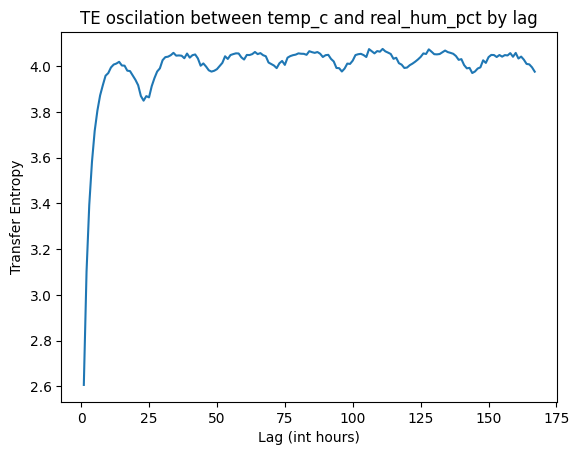

In [107]:
col1 = "temp_c"
col2 = "real_hum_pct"
df_osc_1 = get_oscilations(transfer_entropy_for_weather, col1, col2)
df_osc_1.set_index("Lag", inplace=True)
df_osc_1.sort_index(inplace=True)
df_osc_1.TE.plot()
plt.title(f"TE oscilation between {col1} and {col2} by lag")
plt.xlabel("Lag (int hours)")
plt.ylabel("Transfer Entropy")
plt.show()

/var/folders/sc/92vzjb7j2rg889rjr2c3rd4r0000gn/T/ipykernel_32530/2137135031.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_osc_1.sort_index(inplace=True)


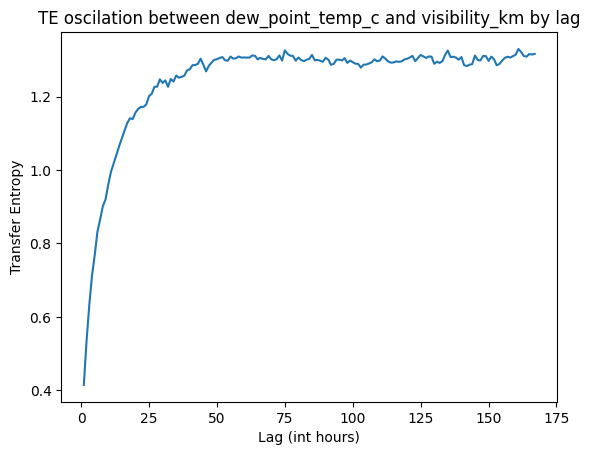

In [108]:
col1 = "dew_point_temp_c"
col2 = "visibility_km"
df_osc_1 = get_oscilations(transfer_entropy_for_weather, col1, col2)
df_osc_1.set_index("Lag", inplace=True)
df_osc_1.sort_index(inplace=True)
df_osc_1.TE.plot()
plt.title(f"TE oscilation between {col1} and {col2} by lag")
plt.xlabel("Lag (int hours)")
plt.ylabel("Transfer Entropy")
plt.show()

There is an increase of transfer entropy between temperature and real humidity % from 1 hour lag to 50

In [109]:
df_transfer_entropy_for_weather = get_lag_of_causality_per_pair(
    transfer_entropy_for_weather, causality_column="TE", is_max=True
)

In [110]:
df_transfer_entropy_for_weather.sort_values(by="TE", ascending=False, inplace=True)
df_transfer_entropy_for_weather

,ColumnX1,ColumnX2,Lag,TE,Orientation
0,dew_point_temp_c,real_hum_pct,111,4.092433,from_1_to_2
10,temp_c,real_hum_pct,111,4.075979,from_1_to_2
323,real_hum_pct,press_kpa,128,3.815822,from_2_to_1
482,temp_c,press_kpa,137,3.617468,from_1_to_2
606,dew_point_temp_c,press_kpa,121,3.560052,from_1_to_2
819,temp_c,dew_point_temp_c,162,2.788516,from_1_to_2
963,real_hum_pct,wind_speed_kmh,110,2.592789,from_2_to_1
1144,temp_c,wind_speed_kmh,155,2.400088,from_2_to_1
1155,dew_point_temp_c,wind_speed_kmh,166,2.373941,from_2_to_1
1457,wind_speed_kmh,press_kpa,137,2.075443,from_1_to_2


In [111]:
df_transfer_entropy_for_weather_summary = add_from_and_to_columns(df_transfer_entropy_for_weather)

In [112]:
df_transfer_entropy_for_weather_summary.drop(
    ["ColumnX1", "ColumnX2", "Orientation"], axis=1, inplace=True
)

In [113]:
df_transfer_entropy_for_weather_summary

,Lag,TE,from_column,to_column
0,111,4.092433,dew_point_temp_c,real_hum_pct
10,111,4.075979,temp_c,real_hum_pct
323,128,3.815822,press_kpa,real_hum_pct
482,137,3.617468,temp_c,press_kpa
606,121,3.560052,dew_point_temp_c,press_kpa
819,162,2.788516,temp_c,dew_point_temp_c
963,110,2.592789,wind_speed_kmh,real_hum_pct
1144,155,2.400088,wind_speed_kmh,temp_c
1155,166,2.373941,wind_speed_kmh,dew_point_temp_c
1457,137,2.075443,wind_speed_kmh,press_kpa


In [114]:
# save as csv
df_transfer_entropy_for_weather_summary.to_csv(
    "../data/results/transfer_entropy_bits.csv", index=False
)

## Print table to LaTex

In [102]:
latex_table = format_and_convert_to_latex(df_transfer_entropy_for_weather_summary, causality_col='TE')
print(latex_table)

\begin{tabular}{llrr}
\toprule
From Column & To Column & Lag (days) & TE \\
\midrule
Dew P. Temp C & Rel Hum \% & 4.62 & 4.09 \\
Temp C & Rel Hum \% & 4.62 & 4.08 \\
Press kPa & Rel Hum \% & 5.33 & 3.82 \\
Temp C & Press kPa & 5.71 & 3.62 \\
Dew P. Temp C & Press kPa & 5.04 & 3.56 \\
Temp C & Dew P. Temp C & 6.75 & 2.79 \\
WindSpeed km/h & Rel Hum \% & 4.58 & 2.59 \\
WindSpeed km/h & Temp C & 6.46 & 2.40 \\
WindSpeed km/h & Dew P. Temp C & 6.92 & 2.37 \\
WindSpeed km/h & Press kPa & 5.71 & 2.08 \\
Visibility km & Dew P. Temp C & 6.71 & 1.33 \\
Visibility km & Temp C & 6.54 & 1.28 \\
Visibility km & Press kPa & 4.38 & 1.23 \\
Visibility km & Rel Hum \% & 3.17 & 1.20 \\
Visibility km & WindSpeed km/h & 0.58 & 0.44 \\
\bottomrule
\end{tabular}



## Presenting the causality

In [62]:
from src.visualisations import plot_dag

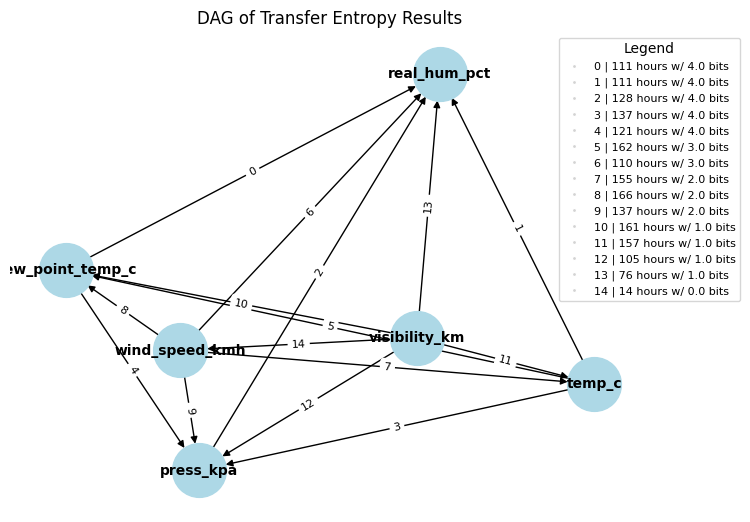

In [103]:
plot_dag(
    df_transfer_entropy_for_weather_summary,
    causality_title="Transfer Entropy",
    causality_column="TE",
    do_convert_the_column_names=True,
)